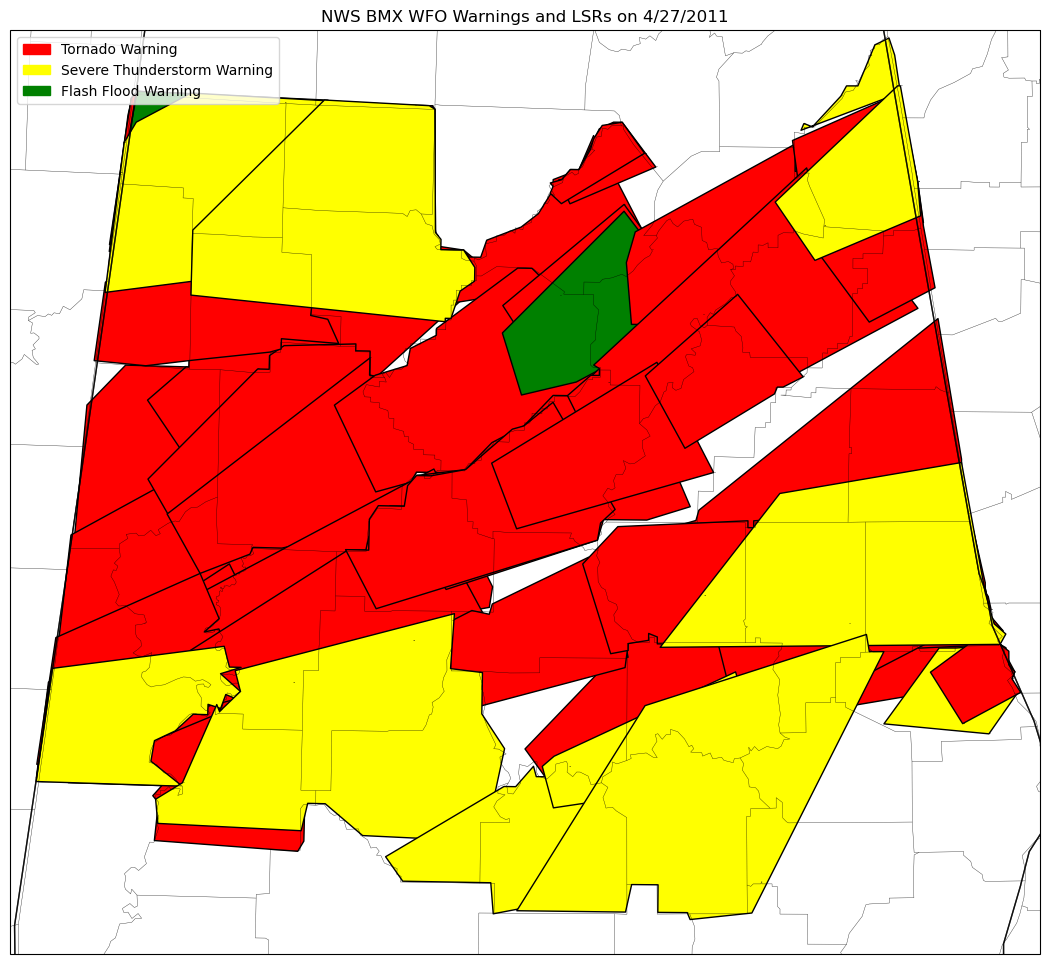

In [11]:
import pandas as pd
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as mplPolygon
from cartopy.mpl.geoaxes import GeoAxes
from metpy.plots import USCOUNTIES
import datetime
import matplotlib.patches as mpatches

tor_url = 'https://www.spc.noaa.gov/climo/reports/230115_rpts_torn.csv'

df_tor = pd.read_csv(tor_url)

hail_url = 'https://www.spc.noaa.gov/climo/reports/230115_rpts_hail.csv'

df_hail = pd.read_csv(hail_url)

wind_url = 'https://www.spc.noaa.gov/climo/reports/230115_rpts_wind.csv'

df_wind = pd.read_csv(wind_url)

for i in range(len(df_wind['Speed'])):
    value = df_wind['Speed'][i]
    if value != 'UNK':
        try:
            df_wind['Speed'][i] = float(value)
        except ValueError:
            df_wind['Speed'][i] = np.nan

url = 'https://mesonet.agron.iastate.edu/api/1/cow.json?wfo=BMX&begints=2011-04-27T12:00:00Z&endts=2011-04-28T12:00:00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrbuffer=15&warningbuffer=1'
response = requests.get(url)
data = response.json()

events = data['events']['features']

warning_data = []

for event in events:
    properties = event['properties']
    geometry = event['geometry']
    
    id = event['id']
    year = properties['year']
    wfo = properties['wfo']
    phenomena = properties['phenomena']
    eventid = properties['eventid']
    issue = properties['issue']
    expire = properties['expire']
    statuses = properties['statuses']
    fcster = properties['fcster']
    significance = properties['significance']
    parea = properties['parea']
    ar_ugcname = properties['ar_ugcname']
    status = properties['status']
    stormreports = properties['stormreports']
    stormreports_all = properties['stormreports_all']
    verify = properties['verify']
    lead0 = properties['lead0']
    areaverify = properties['areaverify']
    sharedborder = properties['sharedborder']

    warning_data.append([id, year, wfo, phenomena, eventid, issue, expire, statuses, fcster, significance,
                         parea, ar_ugcname, status, stormreports, stormreports_all, verify, lead0, areaverify,
                         sharedborder, geometry])

df = pd.DataFrame(warning_data, columns=['id', 'year', 'wfo', 'phenomena', 'eventid', 'issue', 'expire', 'statuses',
                                         'fcster', 'significance', 'parea', 'ar_ugcname', 'status', 'stormreports',
                                         'stormreports_all', 'verify', 'lead0', 'areaverify', 'sharedborder',
                                         'geometry'])

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-85.6, central_latitude=44.3, standard_parallels=(30, 60)))
ax.set_extent([-88.5, -85, 31.85, 34.5])

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), alpha=.75)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

for i in range(len(df_wind['Speed'])):
    value = df_wind['Speed'][i]
    if value != 'UNK':
        try:
            df_wind['Speed'][i] = float(value)
        except ValueError:
            df_wind['Speed'][i] = np.nan
        
for index, row in df_hail.iterrows():
    if row['Size'] >= 200:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), marker='^', c='black', alpha=0.7, s = 150,zorder=2, label = 'Large Hail Report (2"+)')
    else:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), c='green', alpha=0.7, s=150,zorder=2, label='Hail Report')

for index, row in df_wind.iterrows():
    if (row['Speed'] != 'UNK' and row['Speed'] > 65):
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), marker = 's', c='black', alpha=0.7, s=150,zorder=2, label='High Wind Report (65KT+)')
    else:
        ax.scatter(row['Lon'], row['Lat'],transform=ccrs.PlateCarree(), c='blue', alpha=0.7, s=150,zorder=2, label='Wind Report')

ax.scatter(df_tor['Lon'].astype(float), df_tor['Lat'].astype(float), transform=ccrs.PlateCarree(), c='red', label='Tornado Reports', s = 150, zorder=2)

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
#plt.legend(unique_handles, unique_labels, loc='upper right')

colors = {'SV': 'yellow', 'TO': 'red', 'FF': 'green', 'MA': 'orange', 'DS': 'brown'}
color = {'SV': 'yellow', 'TO': 'red', 'FF': 'green'}
zorders = {'TO': 3, 'SV': 2, 'FF': 1}

patches = []
phenomena_colors = []
plotted_warnings = df['phenomena'].unique()
plotted_warnings = set()

for index, row in df.iterrows():
    geometry = row['geometry']
    if geometry:
        if geometry['type'] == 'Polygon':
            coordinates = geometry['coordinates']
            if isinstance(coordinates[0][0], float):
                coordinates = [coordinates]
            for polygon_coords in coordinates:
                polygon = mplPolygon(polygon_coords, closed=True)
                patches.append(polygon)
                phenomena_colors.append(colors.get(row['phenomena'], 'gray'))
                ax.text(polygon_coords[0][0], polygon_coords[0][1], str(row['eventid']), transform=ccrs.PlateCarree(), fontsize=1)
        elif geometry['type'] == 'MultiPolygon':
            polygons = geometry['coordinates']
            for multipolygon_coords in polygons:
                for polygon_coords in multipolygon_coords:
                    polygon = mplPolygon(polygon_coords, closed=True)
                    patches.append(polygon)
                    phenomena_colors.append(colors.get(row['phenomena'], 'gray'))
                    ax.text(polygon_coords[0][0], polygon_coords[0][1], str(row['eventid']), transform=ccrs.PlateCarree(), fontsize=1)
    
    plotted_warnings.add(row['phenomena']) 

collection = PatchCollection(patches, facecolor=phenomena_colors, edgecolor='black', lw=1, transform=ccrs.PlateCarree())
ax.add_collection(collection)

legend_patches = []
legend_labels = []
red_patch = mpatches.Patch(color='red', label='Tornado Warning')
yellow_patch = mpatches.Patch(color='yellow', label='Severe Thunderstorm Warning')
green_patch = mpatches.Patch(color='green', label='Flash Flood Warning')

#for warning in plotted_warnings:
#    if warning in color:
#        legend_patches.append(mplPolygon([[0, 0], [1, 0], [1, 1], [0, 1]], closed=True, fc=color[warning], lw=1, zorder=zorders[warning]))
#        legend_labels.append(warning)

#plt.legend(legend_patches, plotted_warnings, loc='upper left')
plt.legend(handles=[red_patch, yellow_patch, green_patch], loc='upper left')

    
plt.title('NWS BMX WFO Warnings and LSRs on 4/27/2011')

plt.show()
